In [1]:
from scipy.optimize import curve_fit
import pandas as pd
import random
import sys
from IPython.display import clear_output
from matplotlib import pyplot as plt

sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState
from model.amm.agents import Agent
from model.amm.trade_strategies import toxic_asset_attack, omnipool_feeless_arbitrage
from model.amm.global_state import GlobalState, historical_prices

In [2]:
import os
import glob

prefix = 'FTTBUSD'
tick = '1s'

path = 'input/'
extension = 'csv'
os.chdir(path)
result = glob.glob(prefix + '-' + tick + '-' + '*.{}'.format(extension))
os.chdir('..')
# output_filename = 'output/' + prefix + "-" + tick + "-output.csv"

price_data = processing.import_binance_prices(path, result)
price_list = [{'FTT': data.price} for data in price_data[::12]][3500: 15000]
print(price_list[0:10])

[{'FTT': 22.42}, {'FTT': 22.45}, {'FTT': 22.45}, {'FTT': 22.45}, {'FTT': 22.46}, {'FTT': 22.49}, {'FTT': 22.47}, {'FTT': 22.47}, {'FTT': 22.48}, {'FTT': 22.47}]


In [3]:
# same seed, same parameters = same simulation result
random.seed(42)

assets = {
    'HDX': {'usd price': 0.05, 'weight': 0.10},
    'USD': {'usd price': 1, 'weight': 0.20},
    'AUSD': {'usd price': 1, 'weight': 0.10},
    'ETH': {'usd price': 2500, 'weight': 0.40},
    'FTT': {'usd price': price_list[0]['FTT'], 'weight': 0.20}
}

lrna_price_usd = 0.07
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

initial_state = GlobalState(
    pools={
        'Omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
            },
            lrna_fee=0,
            asset_fee=0,
            preferred_stablecoin = 'USD'
        )
    },
    agents={
        # 'Attacker': Agent(
        #     holdings={'USD': 0, 'AUSD': 1000000000},
        #     trade_strategy=toxic_asset_attack(
        #         pool_id='omnipool',
        #         asset_name='AUSD',
        #         trade_size=10000
        #     )
        # ),
        'Arbitrageur': Agent(
            holdings={tkn: 100000000000 for tkn in list(assets.keys()) + ['LRNA']}, 
            trade_strategy=omnipool_feeless_arbitrage('Omnipool')
        )
    },
    evolve_function=historical_prices(price_list),
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets}
)
# print(initial_state)
time_steps = len(price_list) - 1
events = run.run(initial_state, time_steps=time_steps)


Starting simulation...
Execution time: 123.242 seconds.


<AxesSubplot:title={'center':'pool: Omnipool  pool_val  '}>

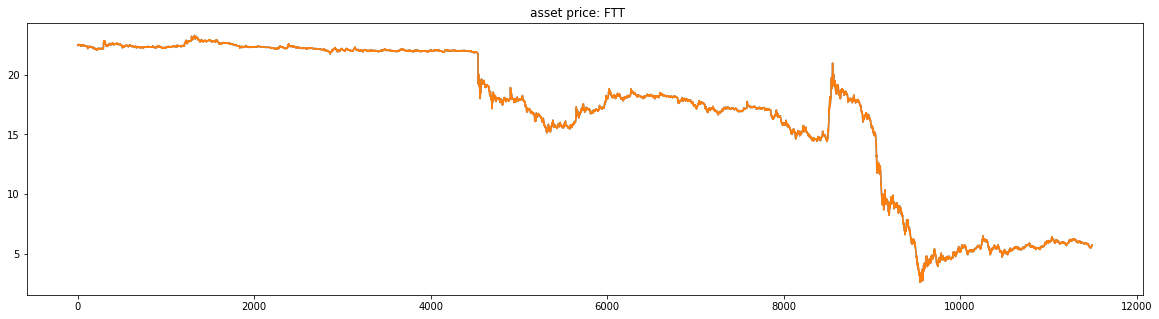

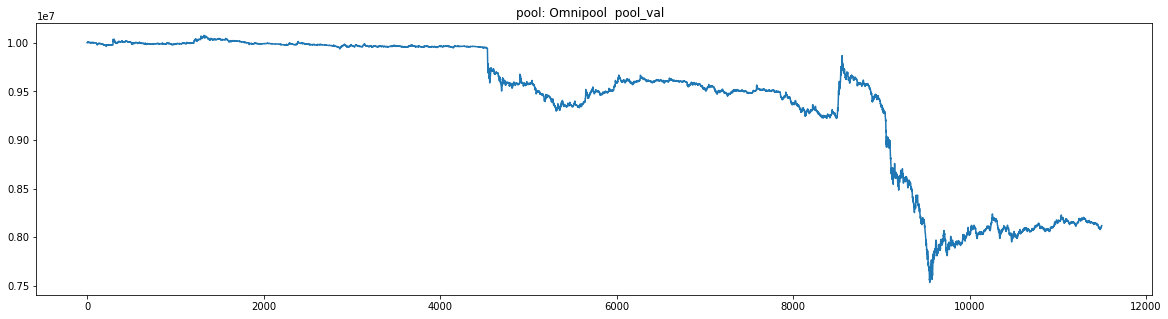

In [4]:
%matplotlib inline
ax = pu.plot(events, asset='FTT')
pu.plot(events, pool='Omnipool', prop='price', key='FTT', subplot=ax)
events = processing.postprocessing(events, optional_params=['pool_val'])
pu.plot(events, pool='Omnipool', prop='pool_val')
# pu.plot(events, pool='Omnipool', prop='price', key=['ETH', 'HDX', 'AUSD'])
# pu.plot(events, pool='Omnipool', prop='liquidity', key='USD')


In [5]:
mitigated_state = initial_state.copy()
def trigger(self: OmnipoolState, tkn: str):
    f = 2
    return max(0.1, min(self.long_oracle[tkn].get('volume_in') / (self.short_oracle[tkn].get('volume_in') or 1) * f, 1))
mitigated_state.pools['Omnipool'].liquidity_coefficient_function = trigger
events2 = run.run(mitigated_state, time_steps)
events2 = processing.postprocessing(events2, optional_params=['pool_val'])

Starting simulation...
Execution time: 124.848 seconds.


Text(0.5, 1.0, 'Percentage of FTT liquidity which is offline')

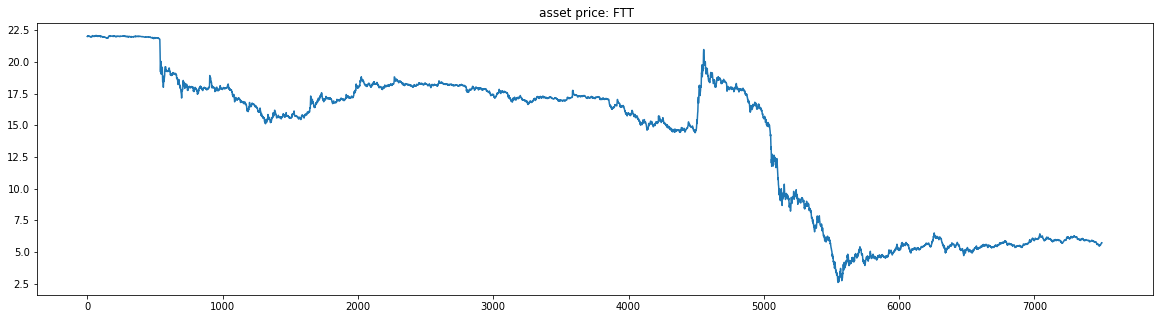

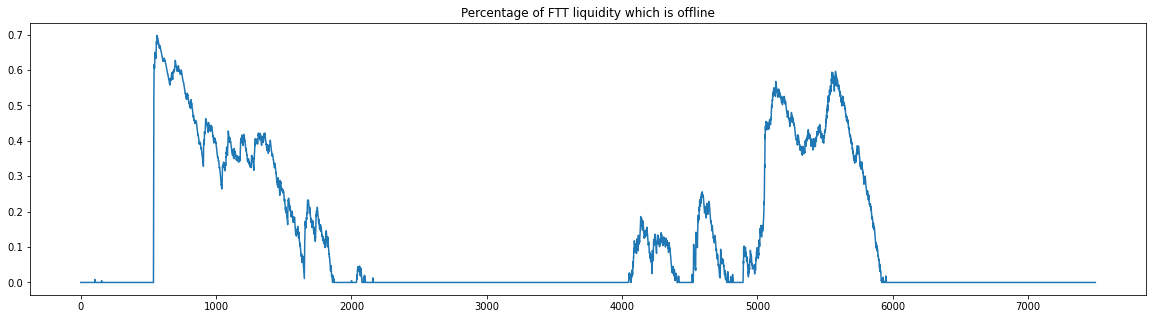

In [6]:
# pu.plot(events2, pool='Omnipool', prop='total_value_locked')
shorter_events = events[4000:]
shorter_events2 = events2[4000:]
ax = pu.plot(shorter_events, asset='FTT')
# pu.plot(events2, pool='Omnipool', prop='price', key='FTT')
# pu.plot(events2, pool='Omnipool', prop='price', key=['ETH', 'HDX', 'AUSD'])
# pu.plot(events2, pool='Omnipool', prop='liquidity', key='USD')
liquidity_offline_percent = [
    p / shorter_events2[i]['state'].pools['Omnipool'].liquidity['FTT'] 
    for i, p in enumerate(pu.get_datastream(shorter_events2, pool='Omnipool', prop='liquidity_offline', key='FTT'))
]
plt.figure(figsize=(20, 5))
plt.plot(range(len(events[4000:])), liquidity_offline_percent)
plt.title('Percentage of FTT liquidity which is offline')


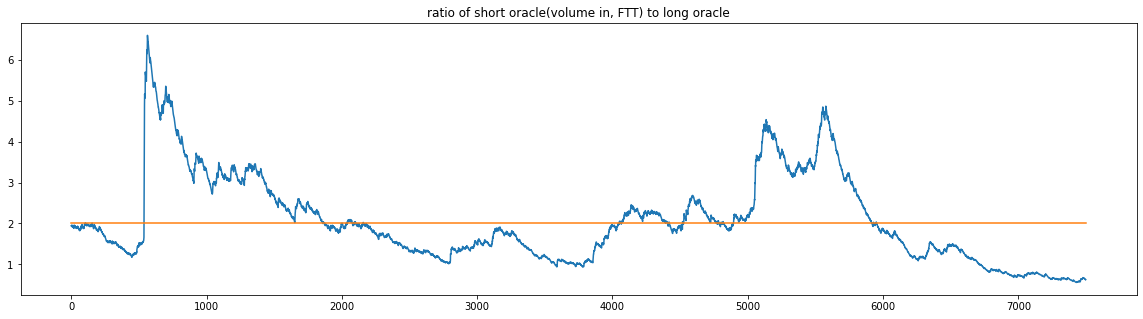

In [7]:
trigger_graph = [
    event['state'].pools['Omnipool'].short_oracle[tkn].get('volume_in') 
    / (event['state'].pools['Omnipool'].long_oracle[tkn].get('volume_in') or 1)
    for event in shorter_events2
]
plt.figure(figsize=(20, 5))
plt.plot(range(len(shorter_events2)), trigger_graph)
plt.plot([0, len(shorter_events)], [2, 2])
# events2 = events2[4000:]
shorter_events2=events2[4000:]
# plt.plot([0, len(events)], [1, 1])
plt.title('ratio of short oracle(volume in, FTT) to long oracle')
lrna_price = [event['state'].pools['Omnipool'].lrna_price('USD') for event in shorter_events2]

In [8]:
lrna_price = [1 / event['state'].pools['Omnipool'].lrna_price('USD') for event in events2]
lrna_total = [event['state'].pools['Omnipool'].lrna_total for event in events2]

In [9]:
# plt.figure(figsize=(20,5))
# plt.plot(range(len(events)), lrna_price)
# plt.figure(figsize=(20,5))
# plt.plot(range(len(events)), lrna_total)
# print(1 - lrna_price[-1]/ lrna_price[0])
events2 = processing.postprocessing(events2, optional_params= ['pool_val'])
shorter_events2 = events2[4000:]

0.052338308489209146036798257585812070901817673575199
8216787.6009485786112214787239801177283201574894904


<AxesSubplot:title={'center':'pool: Omnipool  pool_val  '}>

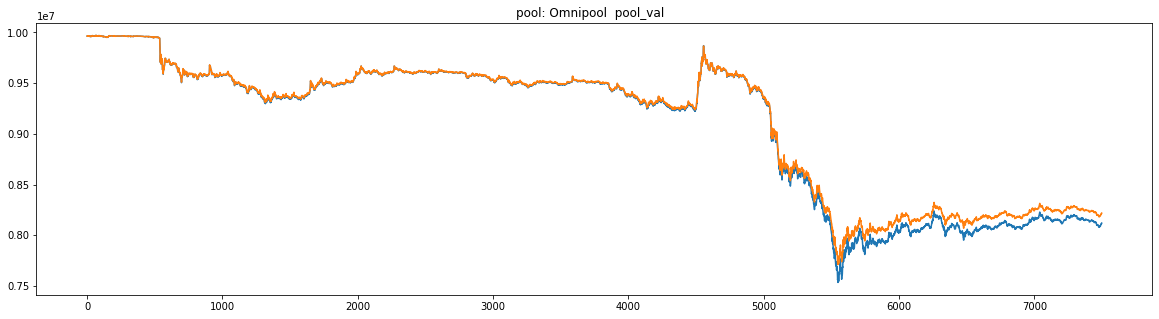

In [10]:
print (1 - (10000000 - (events2[-1]['state'].pools['Omnipool'].pool_val)) / (10000000 - (events[-1]['state'].pools['Omnipool'].pool_val)))
print (events2[-1]['state'].pools['Omnipool'].pool_val)

ax = pu.plot(shorter_events, pool='Omnipool', prop='pool_val')
pu.plot(shorter_events2, pool='Omnipool', prop='pool_val', subplot=ax)